In [45]:
import psana
import numpy as np
from pathlib2 import Path
import os
import pandas as pd
import h5py
from x340helpers import *
from skimage import exposure
from itertools import islice
from pyimgalgos.HPolar import cart2polar
%matplotlib notebook
from matplotlib.pyplot import *

In [2]:
rcParams['figure.figsize'] = 10, 8

In [3]:
def load_image_data(detector, events, threshold=None, cmpars=None, mbits=MbitMask.PIXEL_STATUS, quantiles=[0.1, 99.9]):
    # select detector
    d = detectors[detector]
    nevents = len(events)
    # get frame shape
    s = tuple(d.shape()) # cspad detectors return a np.array for shape instead of tuple

    # allocate space for the calibrated frames
    data = np.empty((nevents,) + s, dtype=np.float32)

    for i,evt in enumerate(events):
        tmp = d.calib(evt, mbits=mbits, cmpars=cmpars)
        data[i] = np.nan if tmp is None else tmp

    data = np.nan_to_num(data) # remove empty frames
    
    vmin, vmax = np.percentile(data, quantiles)
    data_orig = custom_threshold(data, lower=vmin, upper=vmax)
    
    # if no threshold set
    data2 = data_orig if threshold is None else custom_threshold(data, lower=threshold, lvalue=0.)
    return data_orig, data2

In [32]:
expstr = "exp=xppls7917:run=116"
nevents = 500

In [33]:
# cspad mask
cspad_mbits = MbitMask.PIXEL_MASK | MbitMask.PIXEL_STATUS | MbitMask.UNBONDED4 | MbitMask.CSPAD_CENTRAL | MbitMask.EDGE_PIXELS
cspad_threshold = 20.

In [34]:
# create figure directory if it doesn't exist
figdir = Path('figures')
figdir.mkdir(exist_ok=True)

ds = psana.DataSource(expstr + ':idx')
run = next(ds.runs())
event_times = run.times()
count = len(event_times)
detnames = [d[0] if d[1] == '' else d[1] for d in psana.DetNames()]

print('Opened {}, run with {} events'.format(expstr, count))
print('Found {} detectors:'.format(len(detnames)))
for name in detnames:
    print('\t' + name)

# construct detectors
detectors = {name: psana.Detector(name) for name in (detnames[:10] +detnames[13:15])}

# run number for accessing calib-store using detector interface
calib_store_nr = run.run()

# select the first N events
events = [run.event(et) for et in event_times[:nevents]]

Opened exp=xppls7917:run=116, run with 111561 events
Found 15 detectors:
	evr1
	usbencoder
	cspad
	evr0
	epix_1
	EBeam
	PhaseCavity
	FEEGasDetEnergy
	XppMon_Pim0
	XppMon_Pim1
	XppEnds_Ipm0
	XPP-SB2-BMMON
	XPP-SB3-BMMON
	opal_1
	ControlData


In [35]:
cspad_center = [89.2469, 92.4957] # in mm
cspad_radii = [25, 70]
cspad_x, cspad_y = detectors['cspad'].coords_xy(run.run())

cspad_x = (cspad_x/1000 - cspad_center[0]).ravel()
cspad_y = (cspad_y/1000 - cspad_center[1]).ravel()

cspad_r, cspad_theta = cart2polar(cspad_x, cspad_y)
rbinned = np.digitize(cspad_r, [0., cspad_radii[0], cspad_radii[1], 1000])
cspad_shape = detectors['cspad'].shape()
cspad_det = detectors['cspad']
cspad_mask = np.zeros(cspad_shape).ravel()
cspad_mask[rbinned == 2] = 1.
cspad_mask = cspad_mask.reshape(cspad_shape)

In [36]:
figure()
plot(cspad_r, '.')

<IPython.core.display.Javascript object>

In [37]:
cspad_data = load_image_data('cspad', events, threshold=cspad_threshold, mbits=cspad_mbits)

In [38]:
cspad_mask.reshape(detectors['cspad'].shape())

array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.]],

       [[ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

<IPython.core.display.Javascript object>


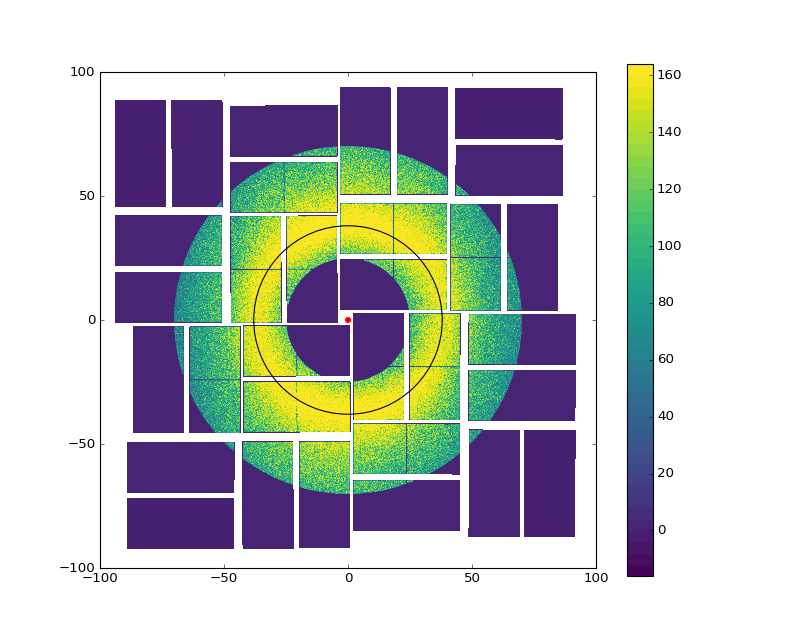

In [23]:
figure()
X = cspad_x.reshape(cspad_shape)
Y = cspad_y.reshape(cspad_shape)
Z = (cspad_data[0]*cspad_mask)[0]
vmin, vmax = np.percentile(Z, [0, 100])
for i in range(cspad_shape[0]):
    tricontourf(X[i].ravel(), Y[i].ravel(), Z[i].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')

ax = gca()
ax.add_patch(matplotlib.patches.Circle((0, 0), radius=38, fill=False))
ax.add_patch(matplotlib.patches.Circle((0, 0), radius=1, fill=True, color='r'))
ax.set_aspect('equal')

colorbar()

<IPython.core.display.Javascript object>


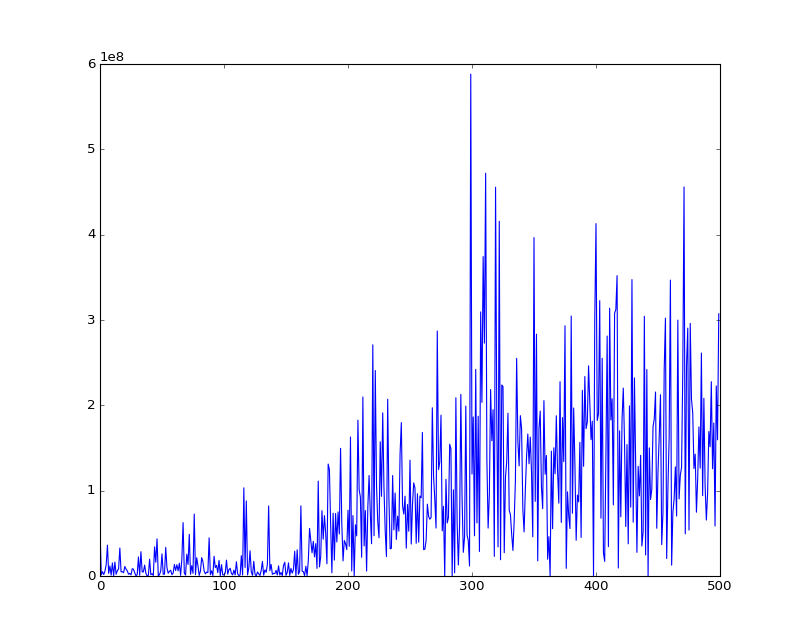

In [39]:
figure()
plot((cspad_data[1]*cspad_mask).reshape(nevents, -1).sum(-1))

In [48]:
#data_dir = '/reg/neh/home/abritz/X340/testrun'
data_dir = '/reg/neh/home/aloukian/Documents/x340'

def construct_dataframe(run, template='xppls7917-run{run}-reduced-test.h5', keys={}):
    path = os.path.join(data_dir, template.format(run=run))
    
    with h5py.File(path, 'r') as sf:
        # process timedeltas
        bitmask = 0xFFFFFFFF
        ns = (sf['timestamps'][:][:]['ts'] & bitmask)
        s = (sf['timestamps'][:][:]['ts'] >> 32)
        ts = s.astype('datetime64[s]') + ns.astype('timedelta64[ns]')
        fiducials = sf['timestamps'][:][:]['fid']
        
        _data_keys = {'timestamps': ts, 'fiducials': fiducials, 'run': int(run)}
        
        for k,v in keys.items():
            name, record = v
            _data_keys.update({k: sf[name][:][:][record]})
            
        data = pd.DataFrame(data=_data_keys)
    return data, str(path)

In [49]:
keys = {
    'step': ['ControlData', 'ccmE_vernier'], 
    'cspad': ['cspad', 'sum'], 
    'cspad_good': ['cspad', 'isgood'],
    'epix': ['epix_1', 'sum'], 
    'epix_good': ['epix_1', 'isgood'],
    'evr0': ['evr0', 'flags'],
}
df, path = construct_dataframe(116, keys=keys)

df

cspad  cspad_good           epix  epix_good  evr0  fiducials  run  \
0    5.624450e+07           1   77713.247467          1     1      80526  116   
1    1.231955e+06           1    3297.901289          1     1      80529  116   
2    5.066186e+06           1   14771.303190          1     1      80532  116   
3    1.757744e+06           1    3947.385889          1     1      80535  116   
4    5.675078e+06           1   17688.407843          1     2      80538  116   
5    1.355625e+07           1   30283.314457          1     1      80541  116   
6    3.613372e+07           1   60688.010307          1     0      80544  116   
7    3.079388e+06           1    8805.884481          1     1      80547  116   
8    1.174985e+07           1   19173.226971          1     1      80550  116   
9    9.901303e+05           1    2966.624346          1     2      80553  116   
10   1.528008e+07           1   23816.295500          1     1      80556  116   
11   2.629537e+05           1     507.364279          1     1      80559  116   
12   1.630554e+07           1   25527.104868          1     1      80562  116   
13   2.008086e+06           1    4438.123079          1     1      80565  116   
14   6.180074e+06           1   16386.025021          1     1      80568  116   
15   8.356979e+06           1   14560.671728          1     1      80571  116   
16   3.278821e+07           1   59227.525042          1     2      80574  116   
17   4.834804e+06           1    8614.530794          1     1      80577  116   
18   5.109819e+06           1   12709.063892          1     0      80580  116   
19   3.887987e+06           1    7820.333733          1     1      80583  116   
20   1.114023e+07           1   19717.450495          1     1      80586  116   
21   8.125436e+06           1   19196.674047          1     2      80589  116   
22   5.955643e+06           1   15146.806110          1     1      80592  116   
23   2.073924e+06           1    4383.043419          1     1      80595  116   
24   3.050385e+06           1    5829.152348          1     1      80598  116   
25   1.359120e+06           1    3992.350912          1     1      80601  116   
26   8.546472e+06           1   17581.891069          1     1      80604  116   
27   7.955386e+06           1   20411.272488          1     1      80607  116   
28   3.705531e+06           1    9630.154472          1     2      80610  116   
29   2.872768e+05           1     866.201820          1     1      80613  116   
..            ...         ...            ...        ...   ...        ...  ...   
470  2.415951e+08           1  299183.008059          1     1      81936  116   
471  4.559324e+08           1  576010.982763          1     1      81939  116   
472  4.940451e+07           1   70488.179358          1     2      81942  116   
473  2.468134e+08           1  305282.085005          1     1      81945  116   
474  2.904752e+08           1  357649.009386          1     0      81948  116   
475  5.378676e+07           1   77746.217388          1     1      81951  116   
476  2.959978e+08           1  373403.168186          1     1      81954  116   
477  2.070650e+08           1  257196.097263          1     2      81957  116   
478  1.915198e+08           1  252016.910488          1     1      81960  116   
479  1.259149e+08           1  175732.250835          1     1      81963  116   
480  1.427699e+08           1  192691.118189          1     1      81966  116   
481  7.474840e+07           1  107527.054319          1     1      81969  116   
482  1.138409e+08           1  147018.799574          1     1      81972  116   
483  1.747409e+08           1  206088.591179          1     1      81975  116   
484  1.264079e+08           1  174935.383533          1     2      81978  116   
485  2.612982e+08           1  328391.143570          1     1      81981  116   
486  9.410035e+07           1  125247.400890          1     0      81984  116   
487  2.082764e+08           1  260772.39811

<IPython.core.display.Javascript object>


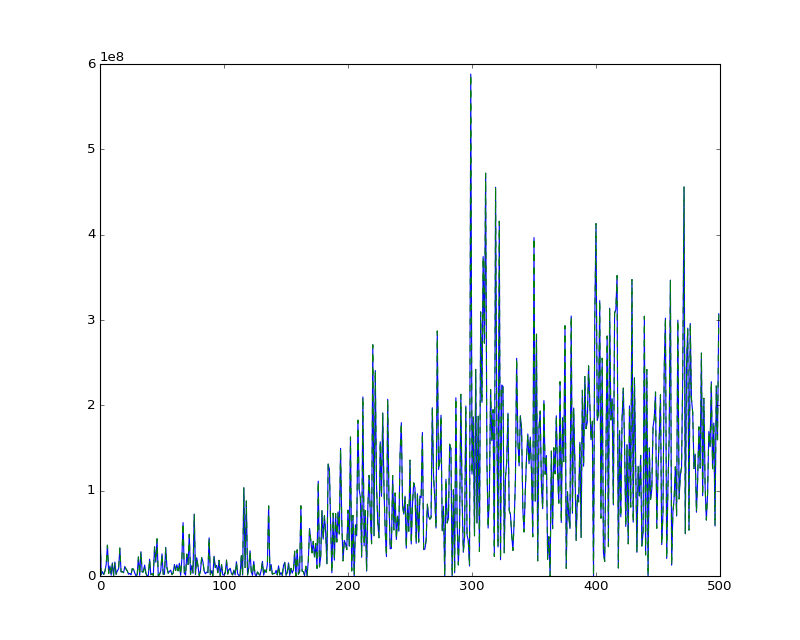

In [52]:
figure()
plot(df['cspad'])
plot((cspad_data[1]*cspad_mask).reshape(nevents, -1).sum(-1), ls='--')


In [55]:
# check epix
epix_mbits = MbitMask.PIXEL_MASK | MbitMask.PIXEL_STATUS
epix_threshold = 20.
epix_data = load_image_data('epix_1', events, threshold=epix_threshold, mbits=epix_mbits)

In [75]:
from skimage import draw
# construct epix circular mask
epix_shape = detectors['epix_1'].shape()
epix_mask = np.zeros(epix_shape, dtype=np.float32)
epix_center = [355.36, 383.879]
epix_radius = 200
cindx = draw.circle(epix_center[0], epix_center[1], epix_radius,
    shape=epix_shape)
epix_mask[cindx] = 1.


In [76]:
figure()
imshow((epix_data[1]*epix_mask).sum(axis=0))

<IPython.core.display.Javascript object>